In [1]:
%matplotlib inline
import io
import h5py
from h5glance import H5Glance
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
import pandas as pd

from cfel_geom import CrystfelGeom  # Local file - move to EXtra-geom later

## Input data

In [2]:
# TODO: use a relative path to data generated in this folder
data_file = "/gpfs/exfel/data/user/juncheng/crystalProject/data/simulation/xstal/xstal100.h5"

In [3]:
f = h5py.File(data_file, 'r')

In [4]:
H5Glance(f)

Here's one frame from the simulation:

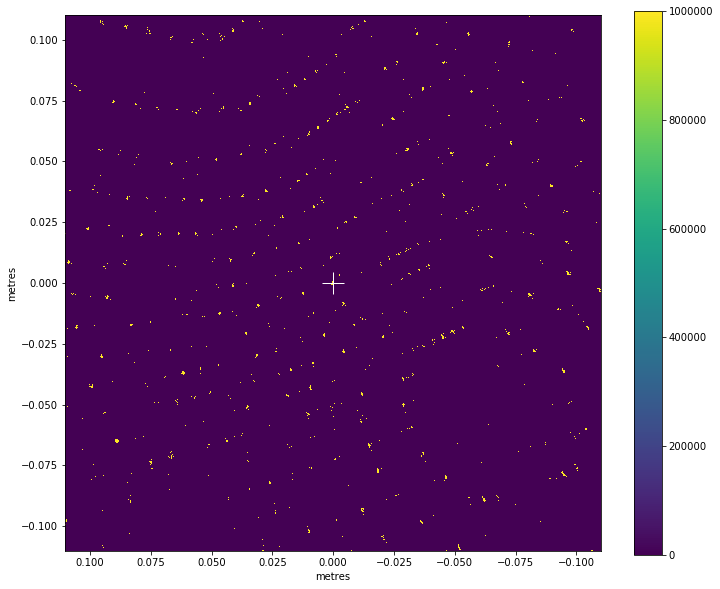

In [5]:
geom = CrystfelGeom.from_crystfel_geom('tmp.geom')
frame = f['data/0000001/data'][:]
fig, ax = plt.subplots(figsize=(12, 10))
geom.plot_data_fast(frame[np.newaxis], axis_units='m', ax=ax)

## Running CrystFEL

In [6]:
with open('test.lst', 'w') as f:
    f.write(f'{data_file}\n')

In [7]:
%%bash
source /usr/share/Modules/init/bash
module load exfel exfel_crystfel

indexamajig -i test.lst -g tmp.geom -o xstal.stream --peaks=zaef -p ./lysozyme-opt.cell

 - EXFEL modulepath enabled
Using version 1.10.4 of HDF5
Using version 1.17 of DirAx
Using XDS BUILT 20180126
Unrecognised field 'px'
Unrecognised field 'py'
Unrecognised field 'pix_width'
Unrecognised field 'd'
No indexing methods specified.  I will try to automatically detect the available methods.
To disable auto-detection of indexing methods, specify which methods to use with --indexing=<methods>.
Use --indexing=none to disable indexing and integration.
This is what I understood your unit cell to be:
tetragonal P, unique axis c, right handed.
a      b      c            alpha   beta  gamma
 78.92  78.92  37.88 A     90.00  90.00  90.00 deg
a =  7.892e-09  0.000e+00  0.000e+00 m
b =  4.832e-25  7.892e-09  0.000e+00 m
c =  2.319e-25  2.319e-25  3.788e-09 m
a* =  1.267e+08 -7.759e-09 -7.759e-09 m^-1 (modulus  1.267e+08 m^-1)
b* =  0.000e+00  1.267e+08 -7.759e-09 m^-1 (modulus  1.267e+08 m^-1)
c* =  0.000e+00  0.000e+00  2.640e+08 m^-1 (modulus  2.640e+08 m^-1)
alpha* =  90.00 deg, beta

## Identified peaks

In [8]:
def read_stream_table(fh, end_marker):
    buf = io.StringIO()
    for line in fh:
        if line.startswith(end_marker):
            buf.seek(0)
            return pd.read_fwf(buf)
        
        buf.write(line)

In [9]:
stream_chunks = {}

with open('xstal.stream', 'r') as f:
    in_peaks_table = False
    chunk_data = {}
    for line in f:
        if '-- Begin chunk --' in line:
            chunk_data = {}
        elif '-- End chunk --' in line:
            if 'event' in chunk_data:
                stream_chunks[chunk_data['event']] = chunk_data
        
        elif line.startswith('Event:'):
            chunk_data['event'] = line.split(':', 1)[1].strip()
        
        elif line.startswith('Peaks from peak search'):
            chunk_data['peaks'] = read_stream_table(f, 'End of peak list')

In [10]:
peak_tbl = stream_chunks['0000001//']['peaks']

In [11]:
module_no = np.zeros(len(peak_tbl), dtype=np.uint32)
peak_coords = geom.data_coords_to_positions(module_no, peak_tbl['ss/px'], peak_tbl['fs/px'])
peak_x = peak_coords[:, 0]
peak_y = peak_coords[:, 1]

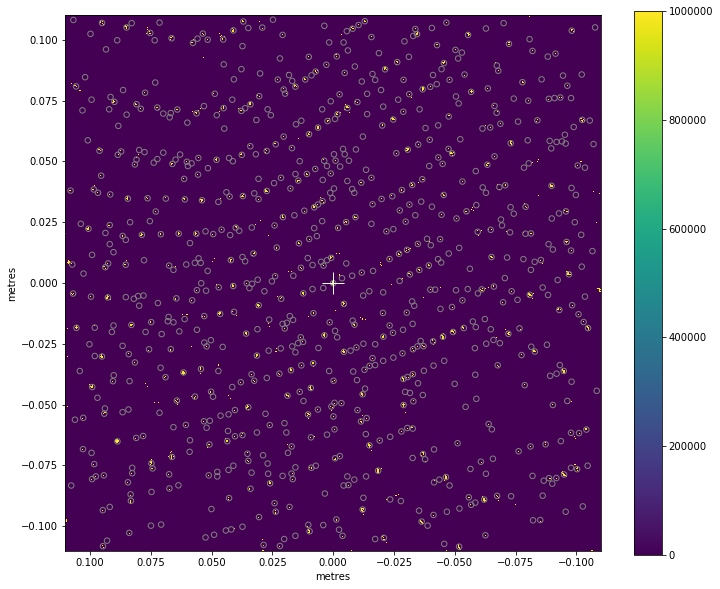

In [12]:
fig, ax = plt.subplots(figsize=(12,10))
geom.plot_data_fast(frame[np.newaxis], axis_units='m', ax=ax)
ax.scatter(peak_x, peak_y, s=30, marker='o', facecolor='none', edgecolor='0.5');

## Examine unit cell parameters

In [13]:
from CrystFEL_Jupyter_utilities.stream_read import search_crystals_parameters

In [14]:
params_lst = search_crystals_parameters('xstal.stream')
params = pd.DataFrame(params_lst).drop(columns='name').rename(columns={'alfa': 'alpha'})
params

,a,b,c,alpha,beta,gamma,centering,lattice_type,unique_axis
0,79.152636,79.036775,37.938009,90.063503,89.903009,90.053819,P,tetragonal,c
1,79.154888,79.051791,38.136338,90.061418,90.136126,89.937623,P,tetragonal,c
2,79.109510,79.021707,37.999625,89.984060,90.038378,89.864990,P,tetragonal,c
3,79.033947,79.117249,37.914329,89.485916,89.943841,89.956342,P,tetragonal,c
4,79.021860,79.097832,38.088441,90.148468,90.005912,90.005705,P,tetragonal,c


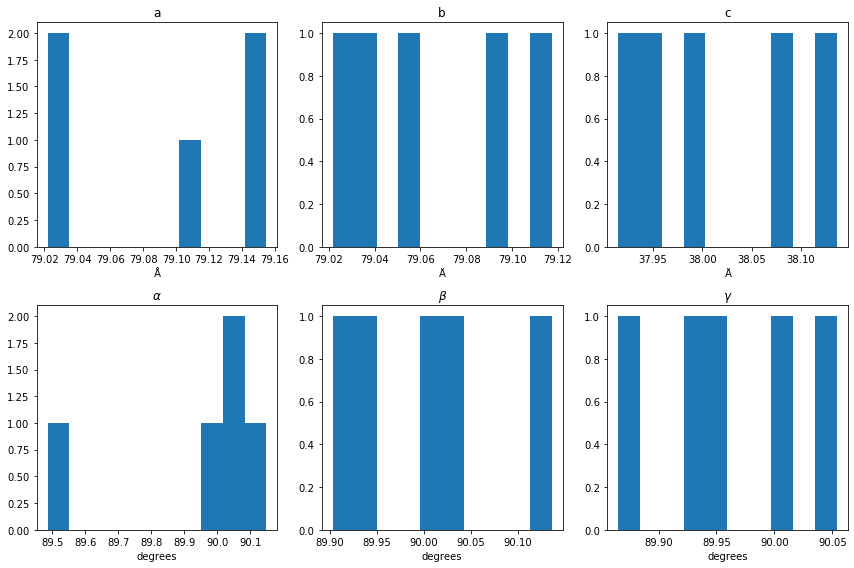

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for name, ax in zip('abc', axes[0]):
    ax.set_title(name)
    ax.set_xlabel("Å")
    ax.hist(params[name])

for name, ax in zip(('alpha', 'beta', 'gamma'), axes[1]):
    ax.set_title(f"$\\{name}$")
    ax.set_xlabel('degrees')
    ax.hist(params[name])

fig.tight_layout()